# VaR Methodologies: Empirical investigation

## Libraries:

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model
import os 
import csv
import pkg_resources
from scipy.stats.distributions import chi2
pkg_resources.require("scipy==1.4.1")
import scipy.stats as sc 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.precision', 4)


## Supporting functions:

In [346]:
def VaRViolations(VaR, Returns, WindowLength, Loss = False):
    """ 
    Simple function that computes binary VaRViolations with or without a quadratic loss function.

    VaR: A dataframe with VaR estimates the same length as Returns.
    Returns: A dataframe with log-returns indexed by a Date object. Date object will be used 
    WindowLength: An integer, defining the windowlength of the rolling forecast. 
    Loss: A boolean value. If true calculates Lopez (1998) VaR violations based on the quadratic loss function. 
    """
    n = len(Returns)

    VaRViolations = 1 * (-VaR[:-1].values > Returns[WindowLength+1:n].values)
    VaRViolations = pd.DataFrame(VaRViolations, index=Returns.index[WindowLength+1:n], dtype = float) #object
    VaRViolations = VaRViolations.rename({0: 'VaR Violations'}, axis = 1)

    if Loss == True:
        VaRViolations = (1 + (Returns[WindowLength+1:n].values + VaR[:-1].values)**2) * (-VaR[:-1].values > Returns[WindowLength+1:n].values)
        VaRViolations = pd.DataFrame(VaRViolations, index=Returns.index[WindowLength+1:n], dtype = float) #object
        VaRViolations = VaRViolations.rename({0: 'VaR Violations'}, axis = 1)

    return(VaRViolations)



def CoverageTest(VaRViolations, alpha, PrintToTerminal = False):
    """Computes the unconditional and conditional coverage tests by Christoffersen for VaR violations.

    Args:
        VaRViolations (dataframe or series): VaRViolations from a Dataframe or Series. 
        alpha (float): coverage level
        PrintToTerminal (bool, optional): If True prints estimates, T-stat and p-value to terminal. Defaults to False.
    """

    VaRViolations = pd.DataFrame(VaRViolations)

    n = len(VaRViolations)
    n_1 =  np.sum(VaRViolations)[0] #.values[0]
    n_0 = float(n - n_1) 
    alpha_hat = n_1 / n

    temp1 = n_0 * np.log(1-alpha_hat) + n_1 * np.log(alpha_hat)
    temp2 = n_0 * np.log(1-alpha) + n_1 * np.log(alpha)

    LR_uc = 2 * (temp1 - temp2)

    p = 1 - chi2.cdf(LR_uc, 1)

    #Conditional coverage:

    #Transitions between 4 states: staying in no-violation (0,0), transition to violation (0,1), staying in violation (1,1) and transitioning to no-violation (1,0). 
    #Code taken from https://www.financialriskforecasting.com/code/PythonJulia8.html
    V = VaRViolations.values
    J = np.full([n, 4], 0)

    for i in range(1, len(VaRViolations)-1,1):
        J[i,0] = (V[i-1] == 0) & (V[i] == 0)
        J[i,1] = (V[i-1] == 0) & (V[i] == 1)
        J[i,2] = (V[i-1] == 1) & (V[i] == 0)
        J[i,3] = (V[i-1] == 1) & (V[i] == 1)

    n_00 = np.sum(J[:,0])
    n_01 = np.sum(J[:,1]) 
    n_10 = np.sum(J[:,2])
    n_11 = np.sum(J[:,3])

    alpha_hat_00 = n_00 / (n_00 + n_01)
    alpha_hat_01 = n_01 / (n_00 + n_01)
    alpha_hat_10 = n_10 / (n_10 + n_11)
    alpha_hat_11 = n_11 / (n_10 + n_11)

    alpha_hat_cc = (n_01 + n_11) / (n_00 + n_01 + n_10 + n_11)

    temp1 = n_00 * np.log(1-alpha_hat_01) + n_01 * np.log(alpha_hat_01) + n_10 * np.log(1-alpha_hat_11) + n_11 * np.log(alpha_hat_11)

    LR_cc = 2 * (temp1 - temp2)
    
    p_cc = 1 - chi2.cdf(LR_cc, 2)

    output, output_cc = [alpha_hat, LR_uc, p], [alpha_hat_cc, LR_cc, p_cc]

    df = pd.DataFrame([pd.Series([alpha_hat, LR_uc, p]),
                      pd.Series([alpha_hat_cc, LR_cc, p_cc])])
    
    df.columns = ["Alpha hat", "Statistic", "p-value"]
    df.index = ["Unconditional", "Conditional"]


    final = np.vstack([output, output_cc])
    text = [ "Unconditional", "Conditional  "]


    if PrintToTerminal == True:
        print('                alpha_hat      Statistic     p-value')
        for i in range(2):
            print('{0:<11}   {1:0.4f}      {2: 0.4f}    {3: 0.4f}'.format(text[i], final[i, 0], final[i, 1], final[i, 2]))

    return(df)



## Downloading SPY prices:

In [471]:
SPYPrices = yf.download("SPY", start = "1997-01-01", end = "2022-04-01")['Adj Close']

SPY = pd.DataFrame(SPYPrices)

[*********************100%***********************]  1 of 1 completed


In [472]:
#Gross returns/ Linear returns 
#SPYreturns = 100 * SPY.pct_change().dropna()

SPYLogreturns = pd.DataFrame(100 * np.diff(np.log(SPY['Adj Close'])))
SPYLogreturns.columns = ['Log-Returns']; 
SPYLogreturns.index = SPY.iloc[1:, ].index
SPYLogreturns.head()

,Log-Returns
Date,
1997-01-02,0.2535
1997-01-03,1.4250
1997-01-06,-0.8778
1997-01-07,1.2101
1997-01-08,-0.8748


## VaR investigation on SPY:

### VaR based on Gaussian and Student's *t* distribution

In [473]:
#We do a rolling 1-step ahead Gaussian VaR forecasts of SPY. Here, the lookback window is set to 8 years: 
WindowLength = 252 * 8
n = len(SPYLogreturns)

estimates = []
for i in range(WindowLength, n, 1):
    temp = SPYLogreturns.iloc[(i - WindowLength):i]
    mu, std = sc.norm.fit(temp)
    estimates.append([mu, std])


estimates = np.array(estimates)

#Gaussian 95% VaR Rolling estimates. 
VaRNormal_95 =  pd.DataFrame(- sc.norm.ppf(0.05, loc = estimates[:,0], scale = estimates[:,1]))
VaRNormal_95 = VaRNormal_95.set_index(SPYLogreturns.index[WindowLength:])
VaRNormal_95 = VaRNormal_95.rename({0: 'VaR Normal 95%'}, axis = 1)

#Gaussian 99% VaR Rolling estimates. 
VaRNormal_99 =  pd.DataFrame(- sc.norm.ppf(0.01, loc = estimates[:,0], scale = estimates[:,1]))
VaRNormal_99 = VaRNormal_99.set_index(SPYLogreturns.index[WindowLength:])
VaRNormal_99 = VaRNormal_99.rename({0: 'VaR Normal 99%'}, axis = 1)

### VaR based on GARCH(1,1) model with *t*-distributed innovations

In [474]:
#Comparing to the 1-step ahead VaR forecasts of a GARCH(1,1) model with t-distributed innovations: 
GarchModel = arch_model(y = SPYLogreturns, mean = 'Zero', vol = 'GARCH', p = 1, o = 0, q = 1, dist = 'studentst', power = 2.0, rescale=False)

#Last observation to fit the GARCH model is day number 1000: 
#GarchFit = GarchModel.fit(last_obs=SPYLogreturns.index[WindowLength], update_freq=1, disp='off')


#Rolling forecasts see p. 30 here, https://readthedocs.org/projects/arch/downloads/pdf/latest/ 
#Parametric VaR at p. 34. 
#Remember horizon=3 implies that it forecasts recursively 3 periods ahead. Set horizon = 1. 
#Scipy have been downgraded to 1.4.1 in order to avoid "ValueError: x0 violates bound constraints."

forecasts = {}
paramEstimates = []
for i in range(WindowLength, n, 1):
    # print(i)
    sys.stdout.flush()
    res = GarchModel.fit(first_obs=(i - WindowLength), last_obs=i, disp="off")
    paramEstimates.append(res.params.transpose())
    temp = res.forecast(horizon=1, reindex=False, method='analytic').variance
    fcast = temp.iloc[0]
    forecasts[fcast.name] = fcast

paramEstimates = pd.DataFrame(paramEstimates)
paramEstimates = paramEstimates.set_index(SPYLogreturns.index[WindowLength:]) 

forecasts = pd.DataFrame(forecasts).T


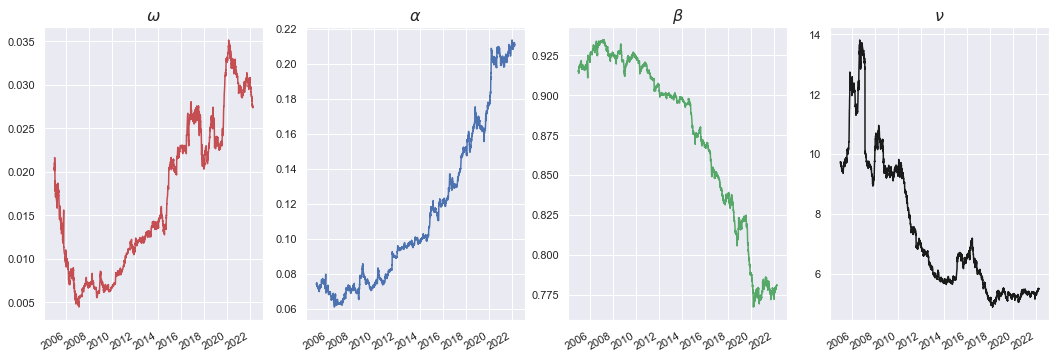

In [475]:
# Plot the evolution of the parameter estimates here. Do 1 x 4 plots.
#paramEstimates.head()

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize=(18,6))

ax[0].plot(SPYLogreturns.index[WindowLength:], paramEstimates['omega'], 'r') #row=0, col=0
ax[1].plot(SPYLogreturns.index[WindowLength:], paramEstimates['alpha[1]'], 'b') #row=1, col=0
ax[2].plot(SPYLogreturns.index[WindowLength:], paramEstimates['beta[1]'], 'g') #row=0, col=1
ax[3].plot(SPYLogreturns.index[WindowLength:], paramEstimates['nu'], 'k') #row=1, col=1
ax[0].set_title(r'$\omega$', fontsize = 16)
ax[1].set_title(r'$\alpha$', fontsize = 16)
ax[2].set_title(r'$\beta$', fontsize = 16)
ax[3].set_title(r'$\nu$', fontsize = 16)

fig.autofmt_xdate()

plt.show()


### Out-of-sample VaR forecasting based on the GARCH(1,1) with Student's t-distributed innovations

In [476]:
# Getting VaR estimate
StudentsTvalues_95 = []
StudentsTvalues_99 = []

for i in range(0, n-WindowLength, 1):
    StudentsTvalues_95.append(-GarchModel.distribution.ppf(0.05, paramEstimates['nu'].iloc[i]))
    StudentsTvalues_99.append(-GarchModel.distribution.ppf(0.01, paramEstimates['nu'].iloc[i]))

StudentsTvalues_95 = pd.DataFrame(StudentsTvalues_95)
StudentsTvalues_99 = pd.DataFrame(StudentsTvalues_99)


#We will negate the term in the analysis.
VaR_Garch_95 =  np.mean(SPYLogreturns).values + np.sqrt(forecasts).values * StudentsTvalues_95

VaR_Garch_95 = VaR_Garch_95.set_index(SPYLogreturns.index[WindowLength:])
VaR_Garch_95 = pd.DataFrame(VaR_Garch_95)
VaR_Garch_95 = VaR_Garch_95.rename({0: 'VaR GARCH 95%'}, axis = 1)

VaR_Garch_99 =  np.mean(SPYLogreturns).values + np.sqrt(forecasts).values * StudentsTvalues_99

VaR_Garch_99 = VaR_Garch_99.set_index(SPYLogreturns.index[WindowLength:])
VaR_Garch_99 = pd.DataFrame(VaR_Garch_99)
VaR_Garch_99 = VaR_Garch_99.rename({0: 'VaR GARCH 99%'}, axis = 1)



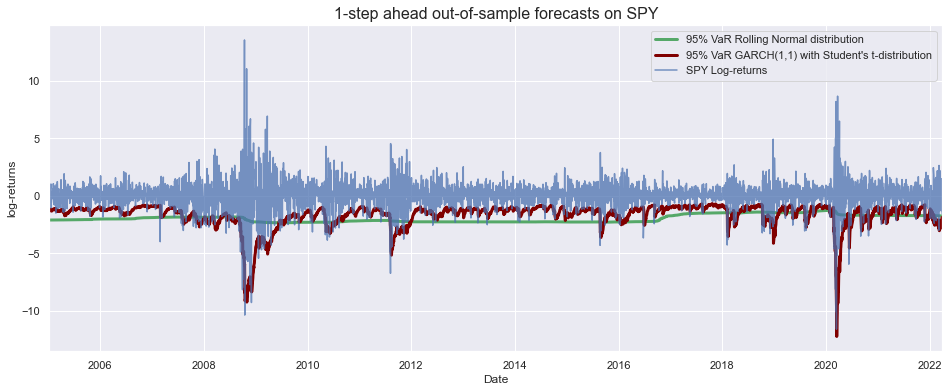

In [477]:
# VaR estimated ex-post at day 2000 is to be used for day 2001. Therefore we have moved the returns by one day, in order to compare the VaR estimates to the realized log-return values.  
sns.set()
sns.color_palette('dark')
plt.figure(figsize=(16,6))
plt.margins(x=0)
plt.plot(SPYLogreturns.index[WindowLength+1:], -VaRNormal_95[:-1], color = 'g', label = '95% VaR Rolling Normal distribution', linewidth = 3) 
plt.plot(SPYLogreturns.index[WindowLength+1:], -VaR_Garch_95[:-1], color = 'maroon', label = "95% VaR GARCH(1,1) with Student's t-distribution", linewidth = 3) #color = 'darkred'
plt.plot(SPYLogreturns.index[WindowLength+1:], SPYLogreturns[WindowLength+1:n], color = 'b', label = 'SPY Log-returns', alpha = 0.75) #color = 'steelblue'
plt.legend()
plt.title('1-step ahead out-of-sample forecasts on SPY', fontsize = 16)
plt.ylabel('log-returns')
plt.xlabel('Date')
plt.show()

### Backtesting VaR models on SPY

#### Failure rates based on the Quadratic loss function

In [478]:
GarchLoss_95 = VaRViolations(VaR_Garch_95, SPYLogreturns, WindowLength, Loss=True)
NormalLoss_95 = VaRViolations(VaRNormal_95, SPYLogreturns, WindowLength, Loss=True)

GarchLoss_99 = VaRViolations(VaR_Garch_99, SPYLogreturns, WindowLength, Loss=True)
NormalLoss_99 = VaRViolations(VaRNormal_99, SPYLogreturns, WindowLength, Loss=True)


data = pd.concat([NormalLoss_95, NormalLoss_99, GarchLoss_95, GarchLoss_99], axis = 1)

data.columns = ["Normal 95%", "Normal 99%", "GARCH 95%", "GARCH 99%"]

Averages = pd.concat([data.mean(), data[data > 0].mean()], axis = 1) 
Averages.columns = ["Averages for all days", "Averages only for distressed days"]

Averages

,Averages for all days,Averages only for distressed days
Normal 95%,0.2351,5.2578
Normal 99%,0.1459,6.5919
GARCH 95%,0.1106,2.1423
GARCH 99%,0.0307,1.9878


#### Basel Trafic light test

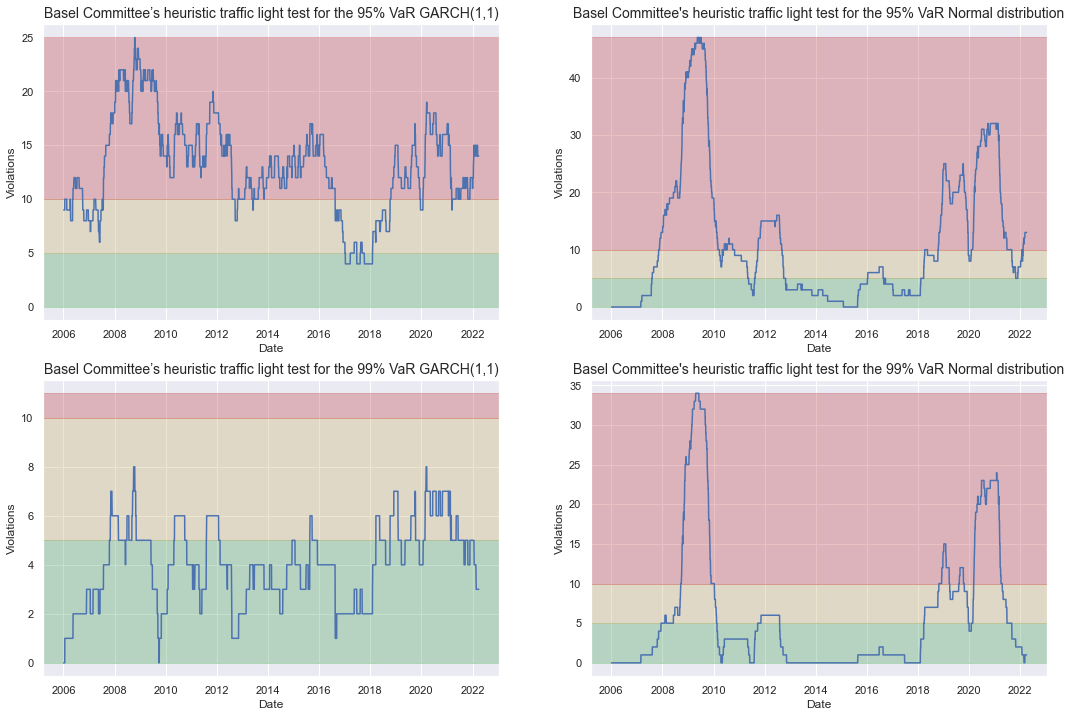

In [480]:
#Doing BASEL test under a rolling forecast period of 250 days. 


GarchViolations_95 = VaRViolations(VaR_Garch_95, SPYLogreturns, WindowLength, Loss=False)
xTGarch_95 = GarchViolations_95.rolling(250).sum()
maxTestGarch_95 = xTGarch_95.max()

NormalViolations_95 = VaRViolations(VaRNormal_95, SPYLogreturns, WindowLength, Loss=False)
xTNormal_95 = NormalViolations_95.rolling(250).sum()
maxTestNormal_95 = xTNormal_95.max()


GarchViolations_99 = VaRViolations(VaR_Garch_99, SPYLogreturns, WindowLength, Loss=False)
xTGarch_99 = GarchViolations_99.rolling(250).sum()
maxTestGarch_99 = xTGarch_99.max()

NormalViolations_99 = VaRViolations(VaRNormal_99, SPYLogreturns, WindowLength, Loss=False)
xTNormal_99 = NormalViolations_99.rolling(250).sum()
maxTestNormal_99 = xTNormal_99.max()



fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(18,12))
ax[0, 0].plot(xTGarch_95)
ax[0, 0].axhspan(0,5, color = 'g', alpha = 0.35)
ax[0, 0].axhspan(5,10, color = 'y', alpha = 0.35)
ax[0, 0].axhspan(10, maxTestGarch_95, color = 'r', alpha = 0.35)
ax[0, 0].set_title('Basel Committee’s heuristic traffic light test for the 95% VaR GARCH(1,1)', fontsize = 14)
ax[0, 0].set(xlabel = 'Date', ylabel = 'Violations') 

ax[0, 1].plot(xTNormal_95)
ax[0, 1].axhspan(0,5, color = 'g', alpha = 0.35)
ax[0, 1].axhspan(5,10, color = 'y', alpha = 0.35)
ax[0, 1].axhspan(10, maxTestNormal_95, color = 'r', alpha = 0.35)
ax[0, 1].set_title("Basel Committee's heuristic traffic light test for the 95% VaR Normal distribution", fontsize = 14)
ax[0, 1].set(xlabel = 'Date', ylabel = 'Violations') 

ax[1,0].plot(xTGarch_99)
ax[1,0].axhspan(0,5, color = 'g', alpha = 0.35)
ax[1,0].axhspan(5,10, color = 'y', alpha = 0.35)
ax[1,0].axhspan(10, 11, color = 'r', alpha = 0.35)
ax[1,0].set_title('Basel Committee’s heuristic traffic light test for the 99% VaR GARCH(1,1)', fontsize = 14)
ax[1,0].set(xlabel = 'Date', ylabel = 'Violations') 

ax[1, 1].plot(xTNormal_99)
ax[1, 1].axhspan(0,5, color = 'g', alpha = 0.35)
ax[1, 1].axhspan(5,10, color = 'y', alpha = 0.35)
ax[1, 1].axhspan(10, maxTestNormal_99, color = 'r', alpha = 0.35)
ax[1, 1].set_title("Basel Committee's heuristic traffic light test for the 99% VaR Normal distribution", fontsize = 14)
ax[1, 1].set(xlabel = 'Date', ylabel = 'Violations') 


plt.show()




#### Unconditional and Conditional Coverage test:

In [419]:
CT_Garch95 = CoverageTest(GarchViolations_95, 0.05, False)
CT_Garch99 = CoverageTest(GarchViolations_99, 0.01, False)

CT_Normal95 = CoverageTest(NormalViolations_95, 0.05, False)
CT_Normal99 = CoverageTest(NormalViolations_99, 0.01, False)

df1 = pd.concat([CT_Garch95, CT_Normal95])
df2 = pd.concat([CT_Garch99, CT_Normal99])

df3 = pd.concat([df1, df2], axis = 1)

df3.index = pd.MultiIndex.from_product([['GARCH', 'Normal'], ['Unconditional', 'Conditional']])
df3.columns = pd.MultiIndex.from_product([ ["95% Value at Risk", "99% Value at Risk"], ["Alpha hat","T-stat", "p-value"]], names = [" ", "Statistics"])
df3.style.set_properties(**{'text-align': 'center'})

df3.style

## A happy coincidence? Backtesting VaR models on multiple equities

### Calculating VaR statistics across 2000+ stocks

**Long computations are skipped. They have been done previously.**

In [11]:
os.chdir("C:/Users/Emil/Desktop/Data for Analysis")
StockData = pd.read_csv("AdjCloseLargeStockDB.csv")
StockData = StockData.set_index('Date')


In [12]:
#Need 8 years of data 252 * 8 + 252 * 2 days out of sample (rule of thumb). 
StockData = StockData.loc[:, StockData.count() >= (252 * 8 + 252 * 2)]
StockData = np.log(StockData).diff() * 100
StockData.drop('1996-12-31', axis = 0, inplace = True)

In [365]:
%%script echo skipping
## Things have already been estimated, and are thus loaded below. 

#Estimating Gaussian distribution parameters for 2000+ stocks: 
# Running this once, then saving it as a pkl file.
Large_Gaussian_Estimates = {}

for j in range(0, StockData.shape[1], 1): #StockData.shape[1]

    n = len(StockData.iloc[:,j].dropna())
    estimates = {}

    for i in range(WindowLength, n, 1):
        temp = StockData.iloc[:,j].dropna()
        temp = temp.iloc[(i - WindowLength):i]
        cast = sc.norm.fit(temp)
        estimates[temp.index[-1]] = cast
        #estimates.append([temp.index[i], mu, std])
    estimates = pd.DataFrame(estimates).T
    estimates = estimates.set_index(pd.to_datetime(estimates.index))
    
    #estimates = np.array(estimates)

    Large_Gaussian_Estimates[StockData.columns[j]] = estimates   

#time: 38 mins

In [366]:
%%script echo skipping
#Converting to dataframe
Large_Gaussian_Estimates_DF = pd.concat([pd.DataFrame(v) for k, v in Large_Gaussian_Estimates.items()], axis = 1, join = 'outer', keys = list(Large_Gaussian_Estimates.keys()))
Large_Gaussian_Estimates_DF = Large_Gaussian_Estimates_DF.rename(columns={0: "Mu", 1: "Sigma"})
#Large_Gaussian_Estimates_DF = Large_Gaussian_Estimates_DF.set_index(StockData.index[WindowLength:n])

In [6]:
#Large_Gaussian_Estimates_DF.to_pickle("Large_Gaussian_Estimates_DF.pkl")
Large_Gaussian_Estimates_DF = pd.read_pickle("Large_Gaussian_Estimates_DF.pkl")
Large_Gaussian_Estimates_DF

A              AA             AAL            AAON          \
                Mu   Sigma      Mu   Sigma      Mu   Sigma      Mu   Sigma   
2005-01-05     NaN     NaN  0.0387  2.3928     NaN     NaN  0.0955  3.0208   
2005-01-06     NaN     NaN  0.0379  2.3923     NaN     NaN  0.0960  3.0204   
2005-01-07     NaN     NaN  0.0362  2.3905     NaN     NaN  0.0954  3.0205   
2005-01-10     NaN     NaN  0.0360  2.3906     NaN     NaN  0.0946  3.0204   
2005-01-11     NaN     NaN  0.0349  2.3913     NaN     NaN  0.0933  3.0205   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2022-03-24  0.0650  1.5778  0.0608  3.2165 -0.0362  3.2244  0.0534  2.0528   
2022-03-25  0.0648  1.5778  0.0591  3.2174 -0.0368  3.2240  0.0525  2.0530   
2022-03-28  0.0647  1.5778  0.0600  3.2172 -0.0344  3.2234  0.0540  2.0518   
2022-03-29  0.0662  1.5784  0.0558  3.2151 -0.0307  3.2248  0.0580  2.0580   
2022-03-30  0.0651  1.5792  0.0574  3.2154 -0.0305  3.2247  0.0583  2.0579   

               AAP          ... ZGNX          ZION            ZNGA          \
                Mu   Sigma  ...   Mu Sigma      Mu   Sigma      Mu   Sigma   
2005-01-05     NaN     NaN  ...  NaN   NaN  0.0529  2.1515     NaN     NaN   
2005-01-06     NaN     NaN  ...  NaN   NaN  0.0538  2.1514     NaN     NaN   
2005-01-07     NaN     NaN  ...  NaN   NaN  0.0518  2.1519     NaN     NaN   
2005-01-10     NaN     NaN  ...  NaN   NaN  0.0507  2.1512     NaN     NaN   
2005-01-11     NaN     NaN  ...  NaN   NaN  0.0505  2.1512     NaN     NaN   
...            ...     ...  ...  ...   ...     ...     ...     ...     ...   
2022-03-24  0.0289  2.0504  ...  NaN   NaN  0.0469  2.1212  0.0327  2.4533   
2022-03-25  0.0296  2.0503  ...  NaN   NaN  0.0482  2.1226  0.0318  2.4525   
2022-03-28  0.0287  2.0509  ...  NaN   NaN  0.0479  2.1228  0.0343  2.4508   
2022-03-29  0.0294  2.0515  ...  NaN   NaN  0.0485  2.1226  0.0361  2.4493   
2022-03-30  0.0283  2.0518  ...  NaN   NaN  0.0460  2.1238  0.0365  2.4492   

              ZUMZ            ZYXI          
                Mu   Sigma      Mu   Sigma  
2005-01-05     NaN     NaN     NaN     NaN  
2005-01-06     NaN     NaN     NaN     NaN  
2005-01-07     NaN     NaN     NaN     NaN  
2005-01-10     NaN     NaN     NaN     NaN  
2005-01-11     NaN     NaN     NaN     NaN  
...            ...     ...     ...     ...  
2022-03-24  0.0221  3.2120  0.1643  6.8277  
2022-03-25  0.0234  3.2112  0.1680  6.8252  
2022-03-28  0.0250  3.2114  0.1669  6.8254  
2022-03-29  0.0273  3.2120  0.1687  6.8247  
2022-03-30  0.0249  3.2138  0.1704  6.8240  

[4339 rows x 4378 columns]

In [ ]:
%%script echo skipping
#Estimating the GARCH model. 

Large_GARCH_Estimates = {}
Large_GARCH_Forecasts = {}
for j in range(0, StockData.shape[1]+1, 1): #StockData.shape[1]

    n = len(StockData.iloc[:,j].dropna())
    estimates = []
    forecasts = {}
    GarchModel = arch_model(y = StockData.iloc[:,j].dropna(), mean = 'Zero', vol = 'GARCH', p = 1, o = 0, q = 1, dist = 'studentst', power = 2.0, rescale=False)

    for i in range(WindowLength, n, 1):
        sys.stdout.flush()
        res = GarchModel.fit(first_obs=(i - WindowLength), last_obs=i, disp="off")
        estimates.append(res.params.transpose())
        temp = res.forecast(horizon=1, reindex=False, method='analytic').variance
        fcast = temp.iloc[0]
        forecasts[fcast.name] = fcast


    forecasts = pd.DataFrame(forecasts).T
    forecasts = forecasts.set_index(pd.to_datetime(forecasts.index))

    estimates = pd.DataFrame(estimates)
    estimates = estimates.set_index(pd.to_datetime(forecasts.index))

    Large_GARCH_Forecasts[StockData.columns[j]] = forecasts
    Large_GARCH_Estimates[StockData.columns[j]] = estimates   
    print("Iteration", j, "Out of",StockData.shape[1])

#2 days 14 hours.
#3660m 47s


In [406]:
%%script echo skipping
Large_GARCH_Estimates_DF = pd.concat([pd.DataFrame(v) for k, v in Large_GARCH_Estimates.items()], axis = 1, keys = list(Large_GARCH_Estimates.keys()))
Large_GARCH_Forecasts_DF = pd.concat([pd.DataFrame(v) for k, v in Large_GARCH_Forecasts.items()], axis = 1, keys = list(Large_GARCH_Forecasts.keys()))
#Large_GARCH_Estimates_DF

In [325]:
#Large_GARCH_Estimates_DF.to_pickle("Large_GARCH_Estimates_DF.pkl")
#Large_GARCH_Forecasts_DF.to_pickle("Large_GARCH_Forecasts_DF.pkl")
Large_GARCH_Estimates_DF = pd.read_pickle("Large_GARCH_Estimates_DF.pkl")
Large_GARCH_Forecasts_DF = pd.read_pickle("Large_GARCH_Forecasts_DF.pkl")



In [ ]:
%%script echo skipping
Large_VaRNormal95 = pd.DataFrame() 
Large_VaRNormal99 = pd.DataFrame() 


for name, col in Large_Gaussian_Estimates_DF:
    temp = pd.DataFrame(-sc.norm.ppf(0.05, loc = Large_Gaussian_Estimates_DF[name]["Mu"], scale = Large_Gaussian_Estimates_DF[name]["Sigma"]))
    temp.columns = [name] 
    Large_VaRNormal95 = pd.concat([Large_VaRNormal95, temp], axis = 1)

    temp2 = pd.DataFrame(-sc.norm.ppf(0.01, loc = Large_Gaussian_Estimates_DF[name]["Mu"], scale = Large_Gaussian_Estimates_DF[name]["Sigma"]))
    temp2.columns = [name] 
    Large_VaRNormal99 = pd.concat([Large_VaRNormal99, temp2], axis = 1)

Large_VaRNormal95 = Large_VaRNormal95.set_index(Large_Gaussian_Estimates_DF.index)
Large_VaRNormal99 = Large_VaRNormal99.set_index(Large_Gaussian_Estimates_DF.index)

In [13]:
#Large_VaRNormal95.to_pickle("Large_VaRNormal95.pkl")
#Large_VaRNormal99.to_pickle("Large_VaRNormal99.pkl")
Large_VaRNormal95 = pd.read_pickle("Large_VaRNormal95.pkl")
Large_VaRNormal99 = pd.read_pickle("Large_VaRNormal99.pkl")

#Duplicates happened, quick fix:
Large_VaRNormal95 = Large_VaRNormal95.loc[:,~Large_VaRNormal95.columns.duplicated()]
Large_VaRNormal99 = Large_VaRNormal99.loc[:,~Large_VaRNormal99.columns.duplicated()]


In [161]:
%%script echo skipping

Large_VaR_Garch_95 = {}
Large_VaR_Garch_99 = {}

for name in StockData: 

    GarchModel = arch_model(y = StockData[name].dropna(), mean = 'Zero', vol = 'GARCH', p = 1, o = 0, q = 1, dist = 'studentst', power = 2.0, rescale=False)

    StudentsTvalues_95 = []
    StudentsTvalues_99 = []

    nNaNs = len(Large_GARCH_Estimates_DF[name]['nu'].dropna())
    for i in range(0, nNaNs, 1):
        StudentsTvalues_95.append(-GarchModel.distribution.ppf(0.05, Large_GARCH_Estimates_DF[name]['nu'].dropna().iloc[i]))
        StudentsTvalues_99.append(-GarchModel.distribution.ppf(0.01, Large_GARCH_Estimates_DF[name]['nu'].dropna().iloc[i]))


    Values_Garch_95 = np.mean(StockData[name].dropna()) + np.sqrt(Large_GARCH_Forecasts_DF[name].dropna()).multiply(StudentsTvalues_95, axis = 0)
    Values_Garch_99 = np.mean(StockData[name].dropna()) + np.sqrt(Large_GARCH_Forecasts_DF[name].dropna()).multiply(StudentsTvalues_99, axis = 0)


    Large_VaR_Garch_95[name] = Values_Garch_95
    Large_VaR_Garch_99[name] = Values_Garch_99


#364m 43s

In [184]:
%%script echo skipping

Large_VaR_Garch_95_DF = pd.concat([pd.DataFrame(v) for k,v in Large_VaR_Garch_95.items()], axis = 1) #keys = list(Large_VaR_Garch_95.keys())
Large_VaR_Garch_95_DF.columns = Large_VaR_Garch_95.keys()

Large_VaR_Garch_99_DF = pd.concat([pd.DataFrame(v) for k,v in Large_VaR_Garch_99.items()], axis = 1) #keys = list(Large_VaR_Garch_99.keys())
Large_VaR_Garch_99_DF.columns = Large_VaR_Garch_99.keys()

Large_VaR_Garch_95_DF.to_pickle("Large_VaR_Garch_95_DF.pkl")
Large_VaR_Garch_99_DF.to_pickle("Large_VaR_Garch_99_DF.pkl")



In [14]:
Large_VaR_Garch_95_DF = pd.read_pickle("Large_VaR_Garch_95_DF.pkl")
Large_VaR_Garch_99_DF = pd.read_pickle("Large_VaR_Garch_99_DF.pkl")

Large_VaR_Garch_99_DF

,A,AA,AAL,AAON,AAP,AAPL,AAT,AAU,AAWW,AAXJ,...,YVR,ZBH,ZBRA,ZEUS,ZG,ZGNX,ZION,ZNGA,ZUMZ,ZYXI
2005-01-05,NaN,3.7625,NaN,8.0745,NaN,6.8524,NaN,NaN,NaN,NaN,...,9.7380,NaN,6.1502,13.0282,NaN,NaN,3.1595,NaN,NaN,NaN
2005-01-06,NaN,3.7116,NaN,7.7975,NaN,6.7398,NaN,NaN,NaN,NaN,...,10.6384,NaN,6.1004,12.4514,NaN,NaN,3.0986,NaN,NaN,NaN
2005-01-07,NaN,3.7106,NaN,7.5742,NaN,9.5318,NaN,NaN,NaN,NaN,...,11.1226,NaN,6.0672,11.8666,NaN,NaN,3.7339,NaN,NaN,NaN
2005-01-10,NaN,3.6666,NaN,7.2923,NaN,8.6060,NaN,NaN,NaN,NaN,...,11.1430,NaN,6.0429,11.3851,NaN,NaN,3.5843,NaN,NaN,NaN
2005-01-11,NaN,3.8852,NaN,7.3127,NaN,10.1763,NaN,NaN,NaN,NaN,...,10.9271,NaN,6.1706,12.9124,NaN,NaN,3.4406,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-24,5.3967,11.7564,10.4299,5.9759,5.0093,5.4234,3.1824,22.1412,6.0750,5.9506,...,22.4231,4.3948,7.2912,11.9280,10.8669,NaN,6.3771,5.1006,8.6242,13.5364
2022-03-25,5.0192,11.6300,10.0381,5.7637,4.9363,5.0998,3.5712,21.3306,5.9650,5.5646,...,22.1996,4.2817,6.8081,12.0539,11.1849,NaN,6.7443,5.2373,8.5715,12.7300
2022-03-28,4.6652,11.3536,9.6684,5.5056,4.9900,4.8174,3.4273,20.4674,5.8560,5.1350,...,19.9370,4.1229,6.4469,11.8087,10.8944,NaN,6.5427,5.2540,8.5311,13.1390
2022-03-29,4.7879,11.1142,9.8981,7.3805,5.0357,4.8790,4.9743,19.7599,5.7412,4.9974,...,18.2057,4.6176,7.0613,11.5222,11.0068,NaN,6.1431,5.1532,8.5315,12.6483


### Backtesting VaR models on 2000+ equities

In [48]:
#Note to self. We are only gonna pursue 99% VaR

# Failure rates: 
WindowLength = 252 * 8

names = Large_VaR_Garch_99_DF.columns
Large_VaRViolations_Garch99_DF = pd.concat([VaRViolations(Large_VaR_Garch_99_DF.loc[:, name], StockData.loc[:, name], WindowLength, Loss = True) for name in names], axis = 1)
Large_VaRViolations_Garch99_DF.columns = names 

Large_Garch99_SummaryStatistics = Large_VaRViolations_Garch99_DF.describe(include = 'all', datetime_is_numeric=False).loc[["mean", "std", "max"],:]
Large_Garch99_SummaryStatistics.columns = names 


Large_VaRViolations_Normal99_DF = pd.concat([VaRViolations(Large_VaRNormal99.loc[:, name], StockData.loc[:, name], WindowLength, Loss = True) for name in names], axis = 1)
Large_Normal99_DF_SummaryStatistics = Large_VaRViolations_Normal99_DF.describe(include='all', datetime_is_numeric=False).loc[["mean", "std", "max"],:]
Large_Normal99_DF_SummaryStatistics.columns = names 
Large_VaRViolations_Normal99_DF.columns = names 


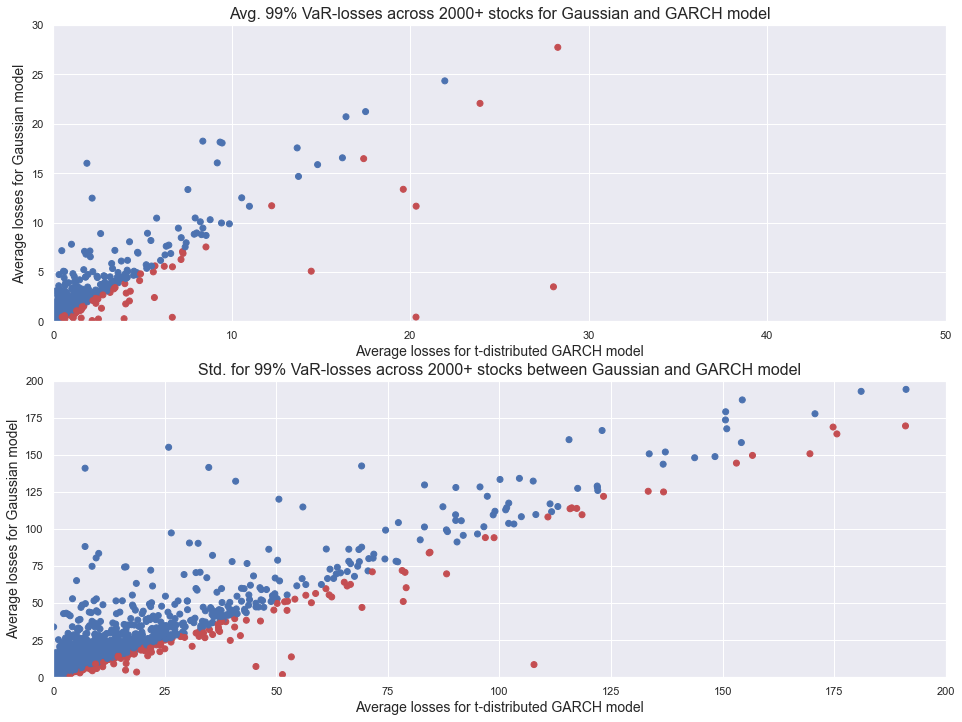

In [32]:
#StockData
AvgExceedance_GARCH = pd.concat([Large_Garch99_SummaryStatistics.loc["mean", :], Large_Normal99_DF_SummaryStatistics.loc["mean",:]], axis = 1)
AvgExceedance_GARCH = (AvgExceedance_GARCH.iloc[:,0] > AvgExceedance_GARCH.iloc[:,1]).values * 1
col = np.where(AvgExceedance_GARCH == 1, 'r', 'b') 

StdExceedance_GARCH = pd.concat([Large_Garch99_SummaryStatistics.loc["std", :], Large_Normal99_DF_SummaryStatistics.loc["std",:]], axis = 1)
StdExceedance_GARCH = (StdExceedance_GARCH.iloc[:,0] > StdExceedance_GARCH.iloc[:,1]).values * 1
col2 = np.where(StdExceedance_GARCH == 1, 'r', 'b') 


fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize=(16,12))
sns.set()
sns.color_palette('dark')
ax[0].margins(x=0)
ax[0].scatter(x = Large_Garch99_SummaryStatistics.loc["mean", :], y = Large_Normal99_DF_SummaryStatistics.loc["mean",:], c = col)
ax[0].set_title('Avg. 99% VaR-losses across 2000+ stocks for Gaussian and GARCH model', fontsize = 16)
ax[0].set_xlabel('Average losses for t-distributed GARCH model', fontsize = 14) 
ax[0].set_ylabel('Average losses for Gaussian model', fontsize = 14) 
ax[0].set_ylim([0,30])
ax[0].set_xlim([0,50])

ax[1].margins(x=0.1)
ax[1].scatter(x = Large_Garch99_SummaryStatistics.loc["std", :], y = Large_Normal99_DF_SummaryStatistics.loc["std",:], c = col2)
ax[1].set_title('Std. for 99% VaR-losses across 2000+ stocks between Gaussian and GARCH model', fontsize = 16)
ax[1].set_xlabel('Average losses for t-distributed GARCH model', fontsize = 14) 
ax[1].set_ylabel('Average losses for Gaussian model', fontsize = 14) 
ax[1].set_ylim([0,200])
ax[1].set_xlim([0,200])


plt.show()
# Red points show the places where the average losses (or standard deviation) for the GARCH model exceeded the average loss (or standard deviation) for the Gaussian model. 128/2189 instances was found for average losses. 

In [81]:
DistressedDays_GARCH99 = [Large_VaRViolations_Garch99_DF.loc[(Large_VaRViolations_Garch99_DF.loc[:, name] > 0), name].mean() for name in names] 
DistressedDays_Normal99 = [Large_VaRViolations_Normal99_DF.loc[(Large_VaRViolations_Normal99_DF.loc[:, name] > 0), name].mean() for name in names] 

table = pd.concat([Large_Normal99_DF_SummaryStatistics.loc['mean',:], pd.DataFrame(DistressedDays_Normal99, index = names), Large_Garch99_SummaryStatistics.loc['mean', :], 
pd.DataFrame(DistressedDays_GARCH99, index = names)], axis = 1)

table.columns = ["Normal 99% Avg. loss over all days", "Normal 99% Avg. loss over distressed days", "GARCH 99% Avg. loss over all days", "GARCH 99% Avg. loss over distressed days"]
table 

,Normal 99% Avg. loss over all days,Normal 99% Avg. loss over distressed days,GARCH 99% Avg. loss over all days,GARCH 99% Avg. loss over distressed days
A,0.1241,7.3464,0.0673,5.2813
AA,0.6259,26.6197,0.1659,12.8546
AAL,0.5845,32.8999,0.1415,10.4353
AAON,0.1700,13.6556,0.0996,13.4990
AAP,0.4116,34.5085,0.3308,36.6508
...,...,...,...,...
ZGNX,2.1188,290.6304,2.2303,367.1087
ZION,0.8213,29.2032,0.1132,8.3204
ZNGA,0.4600,32.8315,0.5091,48.4447
ZUMZ,0.5917,57.5759,0.6443,65.5475


In [82]:
table.mean()

Normal 99% Avg. loss over all days            1.3398
Normal 99% Avg. loss over distressed days    85.5425
GARCH 99% Avg. loss over all days             0.9054
GARCH 99% Avg. loss over distressed days     69.5313
dtype: float64

In [109]:
#For what stocks are the average loss over all days worse for the GARCH model than the Gaussian?
Table2 = table.iloc[:,[0,2]].where(table.iloc[:,0] < table.iloc[:,2]).dropna(axis = 0)
Table2

,Normal 99% Avg. loss over all days,GARCH 99% Avg. loss over all days
ABEV,0.7848,1.2247
AKAM,0.3956,0.5670
AMZN,0.1194,0.1852
APEI,1.0697,1.1004
ARWR,3.0619,4.3262
...,...,...
XXII,2.2807,2.5131
ZGNX,2.1188,2.2303
ZNGA,0.4600,0.5091
ZUMZ,0.5917,0.6443


In [254]:
#Large loss-difference over 5 
dta = Table2.iloc[:,1] - Table2.iloc[:,0]
dta[dta > 5]

AYTU    19.8808
DLPN    24.5164
DSLV     6.6254
NVCN     8.6657
PAYS     6.2563
VTGN     6.2370
VTNR     9.3686
dtype: float64

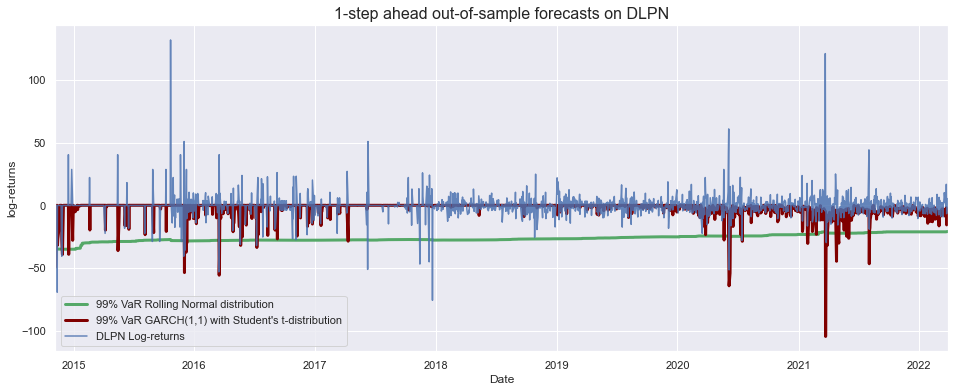

In [323]:
#What happens at DLPN?

ind = Large_VaRNormal99.loc[:,'DLPN'].dropna().index
d = np.where(pd.to_datetime(StockData.loc[:,'DLPN'].index) == ind[0])

sns.set()
sns.color_palette('dark')
plt.figure(figsize=(16,6))
plt.margins(x=0)
plt.plot(ind[1:], -Large_VaRNormal99.loc[:,'DLPN'][:-1].dropna(), color = 'g', label = '99% VaR Rolling Normal distribution', linewidth = 3) 
plt.plot(ind[1:], -Large_VaR_Garch_99_DF.loc[:,'DLPN'][:-1].dropna(), color = 'maroon', label = "99% VaR GARCH(1,1) with Student's t-distribution", linewidth = 3) #color = 'darkred'
plt.plot(ind[1:], StockData.loc[:,'DLPN'][d[0][0]+1:-1], color = 'b', label = 'DLPN Log-returns', alpha = 0.85) #color = 'steelblue'
plt.legend()
plt.title('1-step ahead out-of-sample forecasts on DLPN', fontsize = 16)
plt.ylabel('log-returns')
plt.xlabel('Date')
plt.show()

#There is a clear indication that the stock is illiquid and thus does not provide an adequate fit for the GARCH model. This imposes the question of using simpler VaR-based models when illiquidity (or proper data) is lacking. 

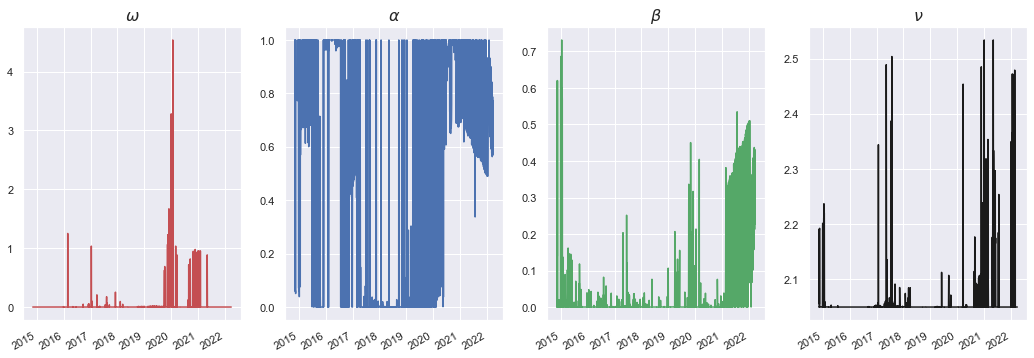

In [330]:
#Garch parameters for DLPN:
paramEstimates = Large_GARCH_Estimates_DF.loc[:,"DLPN"].dropna(axis = 0)

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize=(18,6))

ax[0].plot(paramEstimates['omega'], 'r') #row=0, col=0
ax[1].plot(paramEstimates['alpha[1]'], 'b') #row=1, col=0
ax[2].plot(paramEstimates['beta[1]'], 'g') #row=0, col=1
ax[3].plot(paramEstimates['nu'], 'k') #row=1, col=1
ax[0].set_title(r'$\omega$', fontsize = 16)
ax[1].set_title(r'$\alpha$', fontsize = 16)
ax[2].set_title(r'$\beta$', fontsize = 16)
ax[3].set_title(r'$\nu$', fontsize = 16)

fig.autofmt_xdate()

plt.show()

# Strongly suggest the lack of 'proper' data (noisy or lacking) which also caused some rapid and spurious changes in the parameter estimates. 
# This further strengthens the claim that simpler models (maybe nonparametric ones) should be used for illiquid equities. 

In [354]:
Large_VaRViolations_Garch99_DF_NoLoss = pd.concat([VaRViolations(Large_VaR_Garch_99_DF.loc[:, name], StockData.loc[:, name], WindowLength, Loss = False) for name in names], axis = 1)
Large_VaRViolations_Garch99_DF_NoLoss.columns = names 

Large_VaRViolations_Normal99_DF_NoLoss = pd.concat([VaRViolations(Large_VaRNormal99.loc[:, name], StockData.loc[:, name], WindowLength, Loss = False) for name in names], axis = 1)
Large_VaRViolations_Normal99_DF_NoLoss.columns = names 

tempGARCH99 = {name:CoverageTest(Large_VaRViolations_Garch99_DF_NoLoss.loc[:,name], 0.01, False) for name in names}
tempNormal99 = {name:CoverageTest(Large_VaRViolations_Normal99_DF_NoLoss.loc[:,name], 0.01, False) for name in names}


UncondAndCond_Coverage_GARCH99 = pd.concat([pd.DataFrame(v) for k, v in tempGARCH99.items()], axis = 0, join = 'outer', keys = list(tempGARCH99.keys()))
UncondAndCond_Coverage_Normal99 = pd.concat([pd.DataFrame(v) for k, v in tempNormal99.items()], axis = 0, join = 'outer', keys = list(tempNormal99.keys()))

UncondAndCond_Coverage = pd.concat([UncondAndCond_Coverage_Normal99, UncondAndCond_Coverage_GARCH99], axis = 1)
UncondAndCond_Coverage.columns = pd.MultiIndex.from_product([ ["99% Normal", "99% GARCH"], ["Alpha hat","T-stat", "p-value"]], names = [" ", "Statistics"])

In [355]:
UncondAndCond_Coverage

99% Normal                      99% GARCH                 
Statistics          Alpha hat   T-stat     p-value Alpha hat   T-stat p-value
A    Unconditional     0.0141   6.4192  1.1289e-02    0.0106   0.1567  0.6922
     Conditional       0.0141   7.6205  2.2142e-02    0.0106   2.9198  0.2323
AA   Unconditional     0.0235  57.9786  2.6534e-14    0.0129   3.3967  0.0653
     Conditional       0.0235  79.4403  0.0000e+00    0.0129   5.0236  0.0811
AAL  Unconditional     0.0088   0.7034  4.0164e-01    0.0067   5.4513  0.0196
...                       ...      ...         ...       ...      ...     ...
ZNGA Conditional       0.0018      NaN         NaN    0.0014      NaN     NaN
ZUMZ Unconditional     0.0053  11.6694  6.3538e-04    0.0051  12.9922  0.0003
     Conditional       0.0053      NaN         NaN    0.0051      NaN     NaN
ZYXI Unconditional     0.0081   1.7508  1.8577e-01    0.0108   0.2971  0.5857
     Conditional       0.0081      NaN         NaN    0.0108      NaN     NaN

[4378 rows x 6 columns]

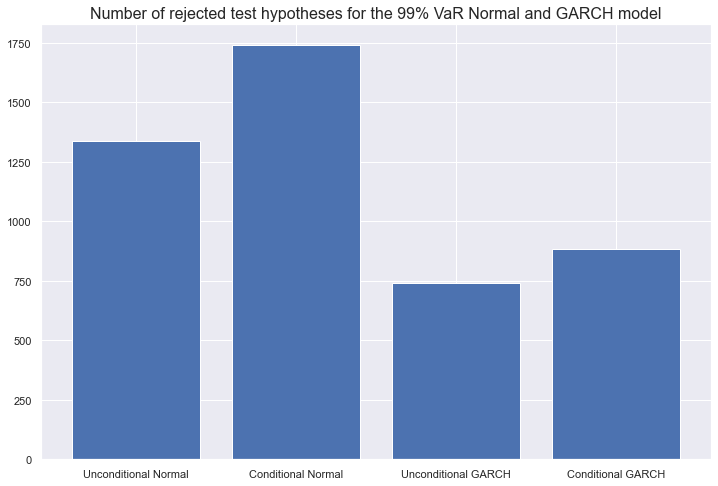

In [421]:
#Testing over multiple stocks might cause the mutliple comparison problem.
Normal99_pvals = UncondAndCond_Coverage.loc[:,["99% Normal"]].where(UncondAndCond_Coverage.loc[:,"99% Normal"].loc[:,"p-value"] < 0.01).dropna(axis = 0)
GARCH99_pvals = UncondAndCond_Coverage.loc[:,["99% GARCH"]].where(UncondAndCond_Coverage.loc[:,"99% GARCH"].loc[:,"p-value"] < 0.01).dropna(axis = 0)


xticks = ["Unconditional Normal", "Conditional Normal", "Unconditional GARCH", "Conditional GARCH"]

bars = [len(Normal99_pvals.xs('Unconditional', level=1, drop_level=False).iloc[:,2]), len(Normal99_pvals.xs('Conditional', level=1, drop_level=False).iloc[:,2]), 
len(GARCH99_pvals.xs('Unconditional', level=1, drop_level=False).iloc[:,2]), len(GARCH99_pvals.xs('Conditional', level=1, drop_level=False).iloc[:,2])]


sns.set()
sns.color_palette('dark')
plt.figure(figsize=(12,8))
plt.bar(xticks, bars)
plt.title("Number of rejected test hypotheses for the 99% VaR Normal and GARCH model", fontsize = 16)
plt.show()

In [457]:
#Idea, give proportion on green, yellow, red: How many days in each. 

Large_VaRViolations_Garch99_DF_NoLoss

TrafficlightGARCH99temp = {name:Large_VaRViolations_Garch99_DF_NoLoss.loc[:,name].rolling(250).sum() for name in names}

TrafficlightGARCH99 = pd.concat([pd.DataFrame(v) for k, v in TrafficlightGARCH99temp.items()], axis = 1, join = 'outer', keys = list(TrafficlightGARCH99temp.keys()))


In [469]:

TrafficlightGarch = {}
temp = []
for name in names:
    for i in range(len(TrafficlightGARCH99.loc[:,name])):
        if i <= 5:
            temp.append("Green")
        if 5 < i <= 10:
            temp.append("Yellow")
        if i > 10:
            temp.append("Red")

    TrafficlightGarch[name] = temp



In [470]:
TrafficlightGarch = pd.concat([pd.DataFrame(v) for k, v in TrafficlightGarch.items()], axis = 1, join = 'outer', keys = list(TrafficlightGarch.keys()))
TrafficlightGarch

KeyboardInterrupt: 